In [1]:
import sys
sys.path.append("../")
import re
from os.path import join
from IPython.display import display

import matplotlib.pyplot as plt
import joblib
import pandas as pd
import numpy as np
import torch
import torch.utils.data as data_utils

from lolip.models.torch_utils.archs import *
from lolip.variables import auto_var
from lolip.models.torch_model import TorchModel
from lolip.utils import estimate_local_lip_v2
from params import mnistLip, cifarLip, svhnLip, mnistOtherLips, mnistFixLips, cifarOtherLips, svhnFixLips
from params import cifarFixLips, svhnOtherLips, resImgFixLips
from utils import params_to_dataframe

auto_var.set_logging_level(0)

In [2]:
from scipy.special import softmax

def get_arch(path):
    return path.split("-")[path.split("-").index('tor')+1]

def get_ds(path):
    return path.split("-")[1]

def predict_real(model, X):
    X = X.transpose(0, 3, 1, 2)
    dataset = data_utils.TensorDataset(torch.from_numpy(X).float())
    loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False, num_workers=2)
    ret = []
    for [x] in loader:
        ret.append(model(x.to('cuda')).detach().cpu().numpy())
    return np.concatenate(ret, axis=0)

def calc_lip(model, X, Xp, top_norm, btm_norm):
    top = np.linalg.norm(predict_real(model, X)-predict_real(model, Xp), ord=top_norm, axis=1)
    down = np.linalg.norm(X.reshape(len(Xp), -1)-Xp.reshape(len(Xp), -1), ord=btm_norm, axis=1)
    return top / (down+1e-6)

def get_lip(model, X, top_norm=2, btm_norm=2, epsilon=1.0):
    lip = estimate_local_lip_v2(model, X, top_norm=top_norm, btm_norm=btm_norm, epsilon=epsilon)
    lip_ = calc_lip(model, X, lip, top_norm=top_norm, btm_norm=btm_norm)
    return lip_

class ModelWrapper():
    def __init__(self, model):
        self.model = model
    def predict_proba(self, X):
        return softmax(predict_real(self.model, X), axis=1)
    def predict_real(self, X):
        return predict_real(self.model, X)
    def predict(self, X):
        return predict_real(self.model, X).argmax(axis=1)
    
cifar_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [3]:
trnX, trny, tstX, tsty = auto_var.get_var_with_argument("dataset", 'cifar10')

In [64]:
def get_proba_list(pred, y):
    pred_proba = pred.max(axis=1)
    pred_y = pred.argmax(axis=1)
    print("accuracy: ", (pred_y == y).mean())
    print("proba dist: ", np.histogram(pred_proba, bins=np.arange(10)/10.)[0])
    acc_list = []
    for i in range(10):
        proba_range = [i/10, (i+1)/10]
        idx = np.where(np.logical_and(pred_proba >= proba_range[0], pred_proba < proba_range[1]))[0]
        if len(idx) > 0:
            acc_list.append((pred_y[idx] == y[idx]).mean())
        else:
            acc_list.append(0.)
    return acc_list

def get_proba_list_fig(proba_list):
    x = np.arange(10) / 10 + 0.05
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.bar(x, proba_list)
    plt.show()
    


accuracy:  0.8019
proba dist:  [   0    2  305  915 1032  990  839  862 1015]


<BarContainer object of 10 artists>

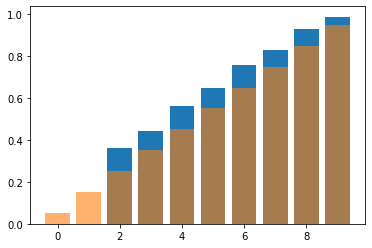

In [75]:
model_path = "../models/pgd-cifar10-0.031-aug01-advce-tor-WRN_40_10-inf-0-ep0120.pt"
model = globals()[get_arch(model_path)](n_classes=10)
model.load_state_dict(torch.load(model_path)['model_state_dict'])
model.eval()
model.cuda()
model = ModelWrapper(model)
#trnX, trny, tstX, tsty = auto_var.get_var_with_argument("dataset", get_ds(model_path))
tst_pred = model.predict_proba(tstX)
proba_list = get_proba_list(tst_pred, tsty)
plt.bar(np.arange(10), proba_list)
plt.bar(np.arange(10), np.arange(10)/10+0.05, alpha = 0.6)

accuracy:  0.9381
proba dist:  [  0   0   0   4  16  79  85 109 142]


<BarContainer object of 10 artists>

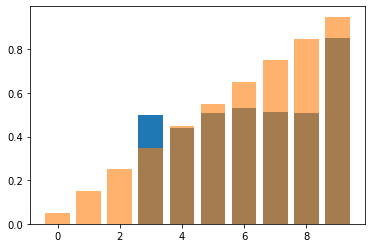

In [74]:
model_path = "../models/pgd-cifar10-0.031-aug01-ce-tor-WRN_40_10-inf-0-ep0120.pt"
model = globals()[get_arch(model_path)](n_classes=10)
model.load_state_dict(torch.load(model_path)['model_state_dict'])
model.eval()
model.cuda()
model = ModelWrapper(model)
tst_pred = model.predict_proba(tstX)
proba_list = get_proba_list(tst_pred, tsty)
plt.bar(np.arange(10), proba_list)
plt.bar(np.arange(10), np.arange(10)/10+0.05, alpha = 0.6)

accuracy:  0.8446
proba dist:  [   0    1  109  442  659  732  742  883 1015]


<BarContainer object of 10 artists>

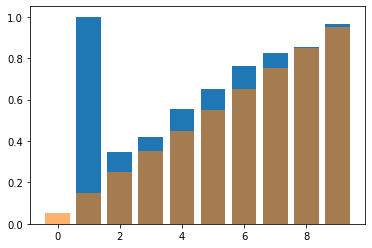

In [73]:
model_path = "../models/pgd-cifar10-0.031-aug01-strades6ce-tor-WRN_40_10-inf-0-ep0120.pt"
model = globals()[get_arch(model_path)](n_classes=10)
model.load_state_dict(torch.load(model_path)['model_state_dict'])
model.eval()
model.cuda()
model = ModelWrapper(model)
tst_pred = model.predict_proba(tstX)
proba_list = get_proba_list(tst_pred, tsty)
plt.bar(np.arange(10), proba_list)
plt.bar(np.arange(10), np.arange(10)/10+0.05, alpha = 0.6)

accuracy:  0.8496
proba dist:  [  0   0   9  99 267 450 403 455 697]


<BarContainer object of 10 artists>

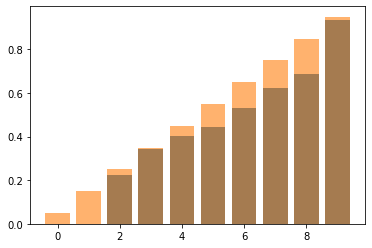

In [76]:
model_path = "../models/pgd-cifar10-0.031-aug01-stradesce-tor-WRN_40_10-inf-0-ep0120.pt"
model = globals()[get_arch(model_path)](n_classes=10)
model.load_state_dict(torch.load(model_path)['model_state_dict'])
model.eval()
model.cuda()
model = ModelWrapper(model)
tst_pred = model.predict_proba(tstX)
proba_list = get_proba_list(tst_pred, tsty)
plt.bar(np.arange(10), proba_list)
plt.bar(np.arange(10), np.arange(10)/10+0.05, alpha = 0.6)